In [1]:
import sys
print('iPython Kernel -->', sys.argv)
print('Environment -->', sys.prefix)

iPython Kernel --> ['C:\\anaconda3\\envs\\ling\\lib\\site-packages\\ipykernel_launcher.py', '-f', 'C:\\Users\\Babak Ravandi\\AppData\\Roaming\\jupyter\\runtime\\kernel-e2d6bb1a-fe0c-43a7-ade1-3ffb76e25aaf.json']
Environment --> C:\anaconda3\envs\ling


In [2]:
import pandas as pd
import numpy as np
import json
from collections import OrderedDict 

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

import random

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns

import networkx as nx
import GraphHierarchy as gh

from tqdm import tqdm

from scipy import stats

import gspread

'''
This layout algorithm requires installin graphviz
https://pygraphviz.github.io/documentation/stable/install.html
'''
from networkx.drawing.nx_agraph import graphviz_layout

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_colwidth', 0)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

%matplotlib inline

In [3]:
import os
from pandas import ExcelWriter


def save_xls(dfs_dict, xls_path, open=False):
    if type(dfs_dict) is not dict:
        dfs_dict = {'sheet1': dfs_dict}
    
    with ExcelWriter(xls_path) as writer:
        for df_name, df in dfs_dict.items():
            df.to_excel(writer, df_name)
        writer.save()

    if open is True:
        os.system('start EXCEL.EXE "{}"'.format(os.path.abspath(xls_path)))
    pass

In [4]:
# https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3/29597209#29597209
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [5]:
def lenght_all_pairs_shortest_path(G_nx):
    q = nx.all_pairs_shortest_path(G_nx)
    
    p_all = []

    for p in q:
        p_all.append(p)

    p_lenght = []
    path_df = []
    
    for p_2 in [p[1].values() for p in p_all]:
        for p3 in p_2:
            p_lenght.append(len(p3))
            
            path_df.append({'l': len(p3), 'p': p3})
#         p_lenght += [len(p3) for p3 in p_2]

        pass
    
    path_df = pd.DataFrame(path_df)
    path_df['p'] = path_df['p'].astype('str')
    
    return path_df

# Load Networks

In [6]:
centuries = {
    '11': 11.0, '12': 12.0, '13': 13.0, '14E': 14.1, '14L': 14.2, '15': 15.0, '16': 16.0, '17': 17.0
}

## Check Mistake Duplicate Edges & Add Frequency

THe only exception of having multiple interactions between a source and target is in 17th century as below. ALl other centuries must have only a single interaction (type of edge) between two nodes.

Source:'PR ze'	 |	Target: 'IV werden'   |   Interactions: {PP, VP}

In [7]:
gc = gspread.service_account(filename='google_service_credentials.json')

In [8]:
google_sheet_ID = '1CWbPlXrKa41DL02mO6pny8BC4Hd7xwbIhA3-ZthyjWc'

german_dataset_gsheet = gc.open_by_key(google_sheet_ID)

german_dataset_gsheet.worksheets()

[<Worksheet '11' id:2063048793>,
 <Worksheet '12' id:936686375>,
 <Worksheet '13' id:698480864>,
 <Worksheet '14E' id:1758104757>,
 <Worksheet '14L' id:1538902914>,
 <Worksheet '15' id:2099895106>,
 <Worksheet '16' id:121866148>,
 <Worksheet '17' id:1360439213>,
 <Worksheet 'Descriptions' id:646251015>,
 <Worksheet 'Shortkeys!' id:1846877574>]

In [9]:
cent_interaction_validate = {}
cent_raw_df = {}
cent_df_dict = {}
'''This is to have the option of more complex network'''
enforce_single_function = True

for cent in centuries.keys():

    print('------------ Cent:', cent)
    
    cent_df = pd.DataFrame(german_dataset_gsheet.worksheet(cent).get_all_records())

    cent_df.loc[:, ['Source', 'Target', 'Interaction']] = (
        cent_df.loc[:, ['Source', 'Target', 'Interaction']].apply(lambda x: x.str.strip(), axis=1)
    ) 
    
    cent_df['Source Funcs All'] = cent_df['Source'].apply(lambda x: x.split(' ')[0])
    cent_df['Source Func Single'] = cent_df['Source Funcs All'].apply(lambda x: x.split('/')[0])

    cent_df['Target Funcs All'] = cent_df['Target'].apply(lambda x: x.split(' ')[0])
    cent_df['Target Func Single'] = cent_df['Target Funcs All'].apply(lambda x: x.split('/')[0])

    cent_df['Source Single Func'] = cent_df['Source Func Single'] + ' ' + cent_df['Source'].apply(lambda x: ' '.join(x.split(' ')[1:]))
    cent_df['Target Single Func'] = cent_df['Target Func Single'] + ' ' + cent_df['Target'].apply(lambda x: ' '.join(x.split(' ')[1:]))

    cent_df['Source All Funcs'] = cent_df['Source']
    cent_df['Target All Funcs'] = cent_df['Target']

    if enforce_single_function is True:
        cent_df['Source'] = cent_df['Source Single Func']
        cent_df['Target'] = cent_df['Target Single Func']

    cent_raw_df[cent] = cent_df.copy()
    
    """"""
    G=nx.from_pandas_edgelist(
        cent_df, source='Source', target='Target', 
        edge_attr=True, create_using=nx.DiGraph()
    )
    
    # nx.draw(G, with_labels=True)
    # print(type(G))
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

    print('num raw edges in dataset:', len(cent_df), ' num network edges:', G.number_of_edges())
    """"""

    cent_df['frequency'] = cent_df['Interaction']

    cent_df = (
        cent_df.groupby(['Source', 'Target'])
        .agg({
            'Interaction': lambda x: set([v.upper() for v in x]),
            'frequency': np.size,
         })
        .reset_index()
    )

    cent_df['Interaction count'] = cent_df['Interaction'].apply(len)

    # print(path_net)
    cent_df = cent_df.sort_values(by=['Interaction count', 'frequency'], ascending=False)

    cent_df_dict[cent] = cent_df
    
    cent_interaction_validate[cent] = cent_df[cent_df['Interaction count'] > 1]  
    
    print(
        'Interaction count > 1 -->', len(cent_interaction_validate[cent])
    )
    
    del cent_df
#     break
    pass
# cent_df_dict.keys()
# cent_df = cent_raw_df[cent]
print('IMP enforce_single_function:', enforce_single_function)

------------ Cent: 11
num raw edges in dataset: 968  num network edges: 730
Interaction count > 1 --> 0
------------ Cent: 12
num raw edges in dataset: 1194  num network edges: 819
Interaction count > 1 --> 0
------------ Cent: 13
num raw edges in dataset: 2503  num network edges: 1361
Interaction count > 1 --> 0
------------ Cent: 14E
num raw edges in dataset: 2326  num network edges: 1353
Interaction count > 1 --> 0
------------ Cent: 14L
num raw edges in dataset: 2494  num network edges: 1626
Interaction count > 1 --> 0
------------ Cent: 15
num raw edges in dataset: 2227  num network edges: 1453
Interaction count > 1 --> 0
------------ Cent: 16
num raw edges in dataset: 3346  num network edges: 2494
Interaction count > 1 --> 0
------------ Cent: 17
num raw edges in dataset: 3940  num network edges: 3121
Interaction count > 1 --> 0
IMP enforce_single_function: False


In [10]:
print('WE MUST HAVE Only two nodes with multiple edges!')
print('NOT ANYMORE! we fixed it')
cent_interaction_validate['17']

WE MUST HAVE Only two nodes with multiple edges!
NOT ANYMORE! we fixed it


,Source,Target,Interaction,frequency,Interaction count


### Check with Legacy

## Tree Specs and Validation

In [11]:
sentence_cent_df = []
G_list = {}
G_not_tree_list = {}
root_codes = [1, -1, -2] # tree, '', cycle (why cycle valentina?)

if enforce_single_function:
    type_source_target = 0
else:
    type_source_target = 1
    pass

print('type_source_target:', type_source_target)

col_source = ['Source Single Func', 'Source All Funcs'][type_source_target]
col_target = ['Target Single Func', 'Target All Funcs'][type_source_target]

for cent in centuries.keys():
#     if cent != '16':
#         continue
        
    print('------------------Cent: {} | {} -> {}------------------'.format(cent, col_source, col_target))
    
    sentence_started = False
    G = None
    row_num = 0
    root_row_num_current = None

    tree_root = None
    is_root_code = None

    G_list[cent] = []
    G_not_tree_list[cent] = []

    for source, target, is_root in cent_raw_df[cent][[col_source, col_target, 'Root']].to_numpy():
        if (sentence_started is True and is_root in root_codes) or (row_num == len(cent_raw_df[cent]) - 1):
            
            # in case no root is marked
            if G is None:
                row_num += 1
                continue
            
            sentence_started = False
           
            diameter_from_all_directed_paths = None
            diemter_from_undirected_graph = None
            diameter_from_positions = None
            
            
            is_tree = nx.is_tree(G)
            
            if(is_tree):    
                path_df = lenght_all_pairs_shortest_path(G)
                diameter_from_all_directed_paths = path_df['l'].max()
                
                diemter_from_undirected_graph = nx.diameter(G.to_undirected())
                
                pos = hierarchy_pos(G, root=tree_root)
                diameter_from_positions =  len(set([v[1] for v in pos.values()]))
                
                if is_root_code != 1:
                    G_not_tree_list[cent].append((root_row_num_current, is_root_code + -0.1, G))
            else:
                G_not_tree_list[cent].append((root_row_num_current, is_root_code, G))
    #             print('not tree')
                pass
            pass
    
            G_list[cent].append({
                'cent': cent,
                'root':tree_root, 
                'root code': is_root_code,
                'is_tree_nx': is_tree,
                'G': G,
                'diameter from all directed paths': diameter_from_all_directed_paths,
                'diameter from undirected graph': diemter_from_undirected_graph,
                'tree height from positions': diameter_from_positions
            })

        #if is_root == 1:
        if is_root in root_codes:
            is_root_code = is_root
            sentence_started = True
            root_row_num_current = row_num
            tree_root = source
            G = nx.DiGraph()
            pass
        
        # in case no root is marked
        if G is not None:
            G.add_edge(source, target)

        row_num += 1
        pass

    del is_root, is_root_code
    print('Num Sentences:', len(G_list[cent]), 'Num NOT trees:', len(G_not_tree_list[cent]))
    
    cent_tree_specs_df = pd.DataFrame(G_list[cent])
    
    if 'is_root' in cent_tree_specs_df:
        print('root code freq:\n', cent_tree_specs_df['is_root'].fillna('NA').value_counts())
    
    sentence_cent_df.append(cent_tree_specs_df)
    pass

sentence_cent_df = pd.concat(sentence_cent_df).reset_index(drop=True)

type_source_target: 1
------------------Cent: 11 | Source All Funcs -> Target All Funcs------------------
Num Sentences: 238 Num NOT trees: 5
------------------Cent: 12 | Source All Funcs -> Target All Funcs------------------
Num Sentences: 302 Num NOT trees: 6
------------------Cent: 13 | Source All Funcs -> Target All Funcs------------------
Num Sentences: 687 Num NOT trees: 6
------------------Cent: 14E | Source All Funcs -> Target All Funcs------------------
Num Sentences: 604 Num NOT trees: 20
------------------Cent: 14L | Source All Funcs -> Target All Funcs------------------
Num Sentences: 569 Num NOT trees: 34
------------------Cent: 15 | Source All Funcs -> Target All Funcs------------------
Num Sentences: 540 Num NOT trees: 22
------------------Cent: 16 | Source All Funcs -> Target All Funcs------------------
Num Sentences: 651 Num NOT trees: 56
------------------Cent: 17 | Source All Funcs -> Target All Funcs------------------
Num Sentences: 724 Num NOT trees: 131


In [12]:
print(len(sentence_cent_df))
sentence_cent_df.head()

4315


,cent,root,root code,is_tree_nx,G,diameter from all directed paths,diameter from undirected graph,tree height from positions
0,11,AX werden,1,True,"(AX werden, PcPs pflanzen, DM/S der, PR zu, N/O jerusalem)",4.0,4.0,4.0
1,11,AX werden,1,True,"(AX werden, PcPs beswichen, PP/S ich, PK niht, PR mit, N/O doctrina, AJ/O perversus)",5.0,5.0,5.0
2,11,V werden,1,True,"(V werden, AD so, N/S auditor, AJ/S din)",3.0,3.0,3.0
3,11,AX sin,1,True,"(AX sin, PcPs werden, PP/S ich, AJ/S edel, PR von, N/O cyprus)",4.0,3.0,4.0
4,11,AX werden,1,True,"(AX werden, PcPs geantvristen)",2.0,1.0,2.0


In [13]:
sentence_cent_df.groupby('cent').agg(
    max_diameter_directed_paths=('diameter from all directed paths', np.max),
    max_diameter_undirected_graph=('diameter from undirected graph', np.max),
    max_tree_height_from_positions=('tree height from positions', np.max)
)

,max_diameter_directed_paths,max_diameter_undirected_graph,max_tree_height_from_positions
cent,,,
11,7.0,7.0,7.0
12,6.0,7.0,6.0
13,6.0,7.0,6.0
14E,7.0,8.0,7.0
14L,6.0,8.0,6.0
15,6.0,7.0,6.0
16,7.0,9.0,7.0
17,8.0,10.0,8.0


### Export Not Trees

In [14]:
path_export_trees_dir = "D:/GoogleDrive/Research/Linguistic project/German/data/export_trees/"
cent = '11'
print('Number of NOT tree items for cent', cent, ':')
pd.DataFrame(G_not_tree_list[cent], columns=['row number', 'root code', 'tree nx'])['root code'].value_counts()
# pd.DataFrame(G_list[cent])['root code'].value_counts()

Number of NOT tree items for cent 11 :


-2    5
Name: root code, dtype: int64

In [15]:
'''
Export Not trees
'''

G_not_tree_list[cent] = sorted(G_not_tree_list[cent], key=lambda x: x[1], reverse=True)

limit_number_nets = 30
not_tree_df = []
num_not_tree = len(G_not_tree_list)
figs = []
ax_index = 0

for i, not_tree in tqdm(enumerate(G_not_tree_list[cent])):
    if i % limit_number_nets == 0:
        plt.close()
        
        fig, axs = plt.subplots(limit_number_nets, figsize=(10, limit_number_nets * 4), dpi=200)
        ax_index = 0
        
        figs.append(fig)
        pass

    not_tree_df.append({'row_num': row_num + 2, 'cent': cent})
    
    row_num, is_root_code, G = not_tree   

    pos=graphviz_layout(G, prog=['dot', 'twopi', 'sfdp', 'circo'][0])

    nx.draw(G, pos=pos, with_labels = True, ax=axs[ax_index])
    axs[ax_index].set_title(
        '--------------------------------------Row Number: {} | code: {} ({} from {})--------------------------------------'.format(
        row_num + 2,
        is_root_code,
        i + 1,
        num_not_tree
    ))
    
    ax_index += 1
    pass

plt.close()

not_tree_df = pd.DataFrame(not_tree_df)
not_tree_df.to_excel(path_export_trees_dir + 'not_tree/cent_{}.xlsx'.format(cent))

for i, fig in enumerate(figs):
    path_fig = path_export_trees_dir + 'not_tree/cent_{}_part_{}.png'.format(cent, i)
    fig.savefig(path_fig, bbox_inches='tight')
    print('Saved fig at: ', path_fig)
    del fig
    pass

del figs
    
print('Cent:', cent)
# plt.tight_layout()

5it [00:00,  5.39it/s]


Saved fig at:  D:/GoogleDrive/Research/Linguistic project/German/data/export_trees/not_tree/cent_11_part_0.png
Cent: 11


Cent: 11
Tree height: 3


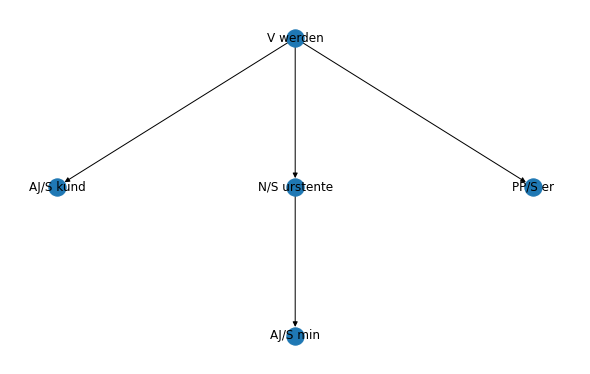

In [16]:
'''
Visualize a Tree
'''
# https://stackoverflow.com/questions/57512155/how-to-draw-a-tree-more-beautifully-in-networkx
# from networkx.drawing.nx_pydot import graphviz_layout
# pos = graphviz_layout(giant, prog="circo")

# https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3/29597209#29597209
plt.figure(figsize=(8, 5)) # , dpi=100
index_tree = [52, 461, 400][0]

tree_root = G_list[cent][index_tree]['root']
G = G_list[cent][index_tree]['G']

pos = hierarchy_pos(G, root=tree_root)

nx.draw(G, pos=pos, with_labels = True)

# nx.draw(giant, pos=nx.spring_layout(giant), with_labels = True)
print('Cent:', cent)
print('Tree height:', len(set([v[1] for v in pos.values()])))

Cent: 11
Tree height: 3 root code: -2


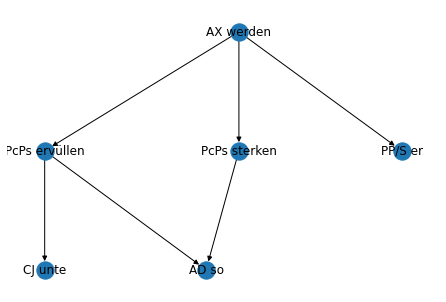

In [17]:
'''
Visualize a not tree sentence
'''
# https://stackoverflow.com/questions/57512155/how-to-draw-a-tree-more-beautifully-in-networkx
# from networkx.drawing.nx_pydot import graphviz_layout
# pos = graphviz_layout(giant, prog="circo")

# https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3/29597209#29597209
index_tree = [0, 515, 400][0]

row_number, root_code, G = G_not_tree_list[cent][index_tree]

pos=graphviz_layout(G, prog=['dot', 'twopi', 'sfdp', 'circo'][0])

nx.draw(G, pos=pos, with_labels = True)

# nx.draw(giant, pos=nx.spring_layout(giant), with_labels = True)
print('Cent:', cent)
print('Tree height:', len(set([v[1] for v in pos.values()])), 'root code:', root_code)

## Create Weighted Networks with Freq

In [18]:
cent_nets = OrderedDict()
syntactic_nets = []

for cent, cent_df in cent_df_dict.items():
    print('------- cent:', cent)
    
#     cent_df = pd.read_excel( path_dataset_dir + path_net).drop(columns='Unnamed: 0')
    
    cent_df['Source'] = cent_df['Source'].str.lower().apply(lambda x: x.split(' ')[0].upper() + ' ' + ' '.join(x.split(' ')[1:]))
    cent_df['Target'] = cent_df['Target'].str.lower().apply(lambda x: x.split(' ')[0].upper() + ' ' + ' '.join(x.split(' ')[1:]))
    
    cent_df.loc[:, 'Source':'Target'] = cent_df.loc[:, 'Source':'Target'].apply(
        lambda x: x.str.strip())
    
#     print(cent_df.columns)
    G = nx.from_pandas_edgelist(
        cent_df, 
        source='Source', 
        target='Target', 
        edge_attr=True,
#         edge_attr=['Interaction', 'frequency', 'Interaction count'], 
#         Created a directed graph
        create_using=nx.DiGraph()
    )
    
    cent_df['cent'] = cent
    syntactic_nets.append(cent_df)
    
    print('n:', G.number_of_nodes(), 'e:', G.number_of_edges())
    
    cent_nets[cent] = G
    pass

syntactic_nets = pd.concat(syntactic_nets).reset_index(drop=True)
syntactic_nets

------- cent: 11
n: 445 e: 728
------- cent: 12
n: 476 e: 819
------- cent: 13
n: 773 e: 1353
------- cent: 14E
n: 745 e: 1349
------- cent: 14L
n: 842 e: 1625
------- cent: 15
n: 803 e: 1453
------- cent: 16
n: 1307 e: 2494
------- cent: 17
n: 1700 e: 3121


,Source,Target,Interaction,frequency,Interaction count,cent
0,AX werden,PP/S er,{VP},43,1,11
1,AX sin,PCPS werden,{VP},11,1,11
2,V werden,PP/S er,{VP},11,1,11
3,AX werden,PK ne,{VP},9,1,11
4,AX werden,PP/S du,{VP},9,1,11
...,...,...,...,...,...,...
12952,V werden,PR allzu,{VP},1,1,17
12953,V werden,PR bei,{VP},1,1,17
12954,V werden,PR hinfür,{VP},1,1,17
12955,V werden,PR von,{VP},1,1,17


In [19]:
if False:
    path_syntactic_nets = path_dataset_dir + 'syntactic_nets_german.xlsx'
    print(path_syntactic_nets)
    syntactic_nets.to_excel(path_syntactic_nets)
    pass

In [20]:
nodes_all_cent = set(syntactic_nets['Source']).union(set(syntactic_nets['Target']))

[n for n in nodes_all_cent if 'werden' in n]

['AX werden', 'PCPS werden', 'IV werden', 'V werden']

### Validation | TODO FIX!!!

In [21]:
# syntactic_nets.to_csv('german_ling_netwrok.csv')

In [22]:
syntactic_nets['Interaction str'] = syntactic_nets['Interaction'].astype(str)

syntactic_nets[syntactic_nets['Interaction str'] == "{''}"]

,Source,Target,Interaction,frequency,Interaction count,cent,Interaction str


In [23]:
'''
The ones with count = 1 seems to have an issue
'''

cent_interaction_count = syntactic_nets.groupby(['cent', 'Interaction str']).agg(
    count = ('Interaction', np.size),
#     source = ('Source', lambda x: set(x)),
#     target = ('Target', lambda x: set(x))
)
if False:
    cent_interaction_count.to_excel('cent_interaction_count.xlsx')
    pass

cent_interaction_count

count
cent Interaction str       
11   {'NP'}           165  
     {'PP'}           83   
     {'VP'}           482  
12   {'NP'}           208  
     {'PP'}           80   
     {'VP'}           531  
13   {'NP'}           342  
     {'PP'}           180  
     {'VP'}           839  
14E  {'NP'}           356  
     {'PP'}           121  
     {'VP'}           876  
14L  {'NP'}           482  
     {'PP'}           172  
     {'VP'}           972  
15   {'NP'}           396  
     {'PP'}           141  
     {'VP'}           916  
16   {'NP'}           702  
     {'PP'}           317  
     {'VP'}           1475 
17   {'NP'}           921  
     {'PP'}           420  
     {'VP'}           1780

In [24]:
G.get_edge_data('AX werden','PP er')
# cent_df
# pd.read_excel( path_dataset_dir + path_net)
# path_dataset_dir + path_net

# Analyze Diameter

In [25]:
diameter_cent_df = []

for cent, cent_G in tqdm(cent_nets.items()):
    path_df = lenght_all_pairs_shortest_path(cent_nets[cent])

    diameter_cent_df.append({
        'cent': cent,
        'avg pairwise shortest path': path_df['l'].mean(),
        'sentence height avg': sentence_cent_df[sentence_cent_df['cent'] == cent]['diameter from all directed paths'].mean(),
                
        'diameter (max pairwise shortest path)': path_df['l'].max(),
        'sentence height max': sentence_cent_df[sentence_cent_df['cent'] == cent]['diameter from all directed paths'].max(),
        
        'avg pairwise shortest path std': path_df['l'].std(),
        'sentence height std': sentence_cent_df[sentence_cent_df['cent'] == cent]['diameter from all directed paths'].std()
    })
    pass

diameter_cent_df = pd.DataFrame(diameter_cent_df)
diameter_cent_df

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.29it/s]


,cent,avg pairwise shortest path,sentence height avg,diameter (max pairwise shortest path),sentence height max,avg pairwise shortest path std,sentence height std
0,11,3.050892,3.429185,7,7.0,1.137608,1.176423
1,12,3.004048,3.439189,6,6.0,1.085827,1.093750
2,13,3.795895,3.223201,9,6.0,1.533649,1.129858
3,14E,3.061681,3.159247,6,7.0,1.006472,1.004441
4,14L,3.249314,3.386916,7,6.0,1.079190,1.062564
5,15,3.265902,3.307692,6,6.0,1.174741,1.037606
6,16,3.871366,3.819200,9,7.0,1.403455,1.141138
7,17,6.750983,3.983728,15,8.0,2.321057,1.230971


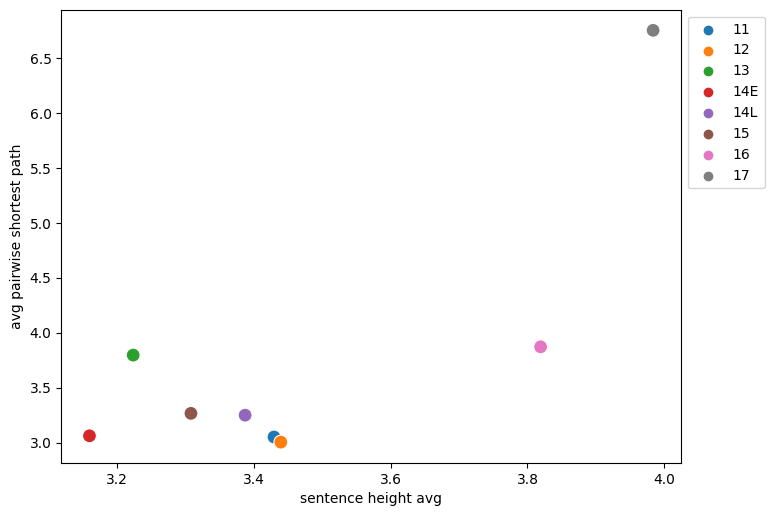

In [26]:
plt.figure(figsize=(8, 6), dpi=100)
ax = sns.scatterplot(data=diameter_cent_df, x="sentence height avg", y="avg pairwise shortest path", hue='cent',
               s=100, legend='full')
ax.legend(bbox_to_anchor=(1, 1))

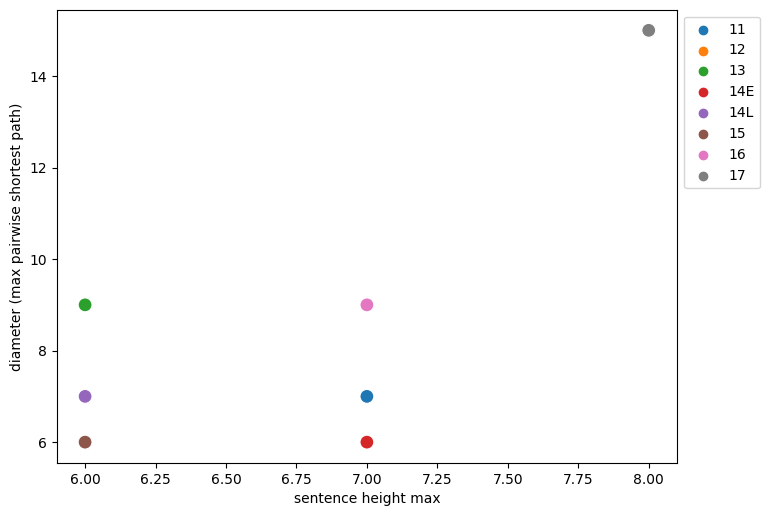

In [27]:
plt.figure(figsize=(8, 6), dpi=100)
ax = sns.scatterplot(data=diameter_cent_df, x="sentence height max", y="diameter (max pairwise shortest path)", hue='cent',
               s=100, legend='full')
ax.legend(bbox_to_anchor=(1, 1))

cent_diameter: 15 from 257537 all-pairs-paths


<AxesSubplot:xlabel='l', ylabel='Count'>

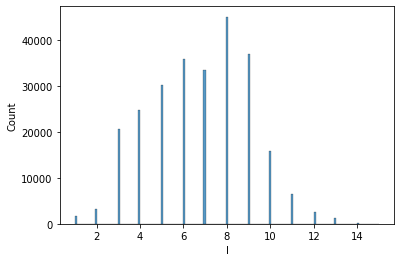

In [28]:
cent = '17'
path_df = lenght_all_pairs_shortest_path(cent_nets[cent])
cent_max_diameter = path_df['l'].max()
print('cent_diameter:', cent_max_diameter, 'from', len(path_df), 'all-pairs-paths')
sns.histplot(path_df['l'])

max tree diameter: 8.0


<AxesSubplot:xlabel='diameter from all directed paths', ylabel='Count'>

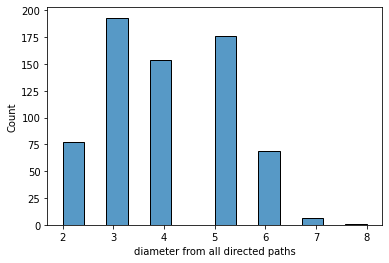

In [29]:
print('max tree diameter:', sentence_cent_df[sentence_cent_df['cent'] == cent]['diameter from all directed paths'].max())
sns.histplot(sentence_cent_df[sentence_cent_df['cent'] == cent]['diameter from all directed paths'])

In [30]:
path_df[path_df['l'] == cent_max_diameter].drop_duplicates('p')

,l,p
134869,15,"['N/S gut', 'N/S viel', 'N/S nicht', 'PR ane', 'N/O munition', 'PR mit', 'N/O graf', 'PR von', 'N/O reich', 'PR wegen', 'N/O auffhebung', 'N/O belagerung', 'PR vor', 'N/O ritter', 'AJ/O bast']"
134870,15,"['N/S gut', 'N/S viel', 'N/S nicht', 'PR ane', 'N/O munition', 'PR mit', 'N/O zeit', 'AJ/O viel', 'PR ze', 'IV werden', 'IV sin', 'AD wie', 'N/S herz', 'N/S clara', 'AJ/S heilig']"
134871,15,"['N/S gut', 'N/S viel', 'N/S nicht', 'PR ane', 'N/O munition', 'PR mit', 'N/O zeit', 'AJ/O viel', 'PR ze', 'IV werden', 'IV sin', 'AD wie', 'N/S herz', 'N/S lehrer', 'AJ/S reich']"
134872,15,"['N/S gut', 'N/S viel', 'N/S nicht', 'PR ane', 'N/O munition', 'PR mit', 'N/O zeit', 'AJ/O viel', 'PR ze', 'IV werden', 'IV sin', 'AD wie', 'N/S herz', 'N/S lehrer', 'N/S augustini']"
134873,15,"['N/S gut', 'N/S viel', 'N/S nicht', 'PR ane', 'N/O munition', 'PR mit', 'N/O zeit', 'AJ/O viel', 'PR ze', 'IV werden', 'IV sin', 'AD wie', 'N/S herz', 'N/S mann', 'AJ/S gottselig']"
134874,15,"['N/S gut', 'N/S viel', 'N/S nicht', 'PR ane', 'N/O munition', 'PR mit', 'N/O zeit', 'AJ/O viel', 'PR ze', 'IV werden', 'IV sin', 'AD wie', 'N/S herz', 'N/S mann', 'N/S francisco']"
134875,15,"['N/S gut', 'N/S viel', 'N/S nicht', 'PR ane', 'N/O munition', 'PR mit', 'N/O zeit', 'AJ/O viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS finden', 'N/O meile', 'AJ/O halbe']"
134876,15,"['N/S gut', 'N/S viel', 'N/S nicht', 'PR ane', 'N/O munition', 'PR mit', 'N/O zeit', 'AJ/O viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS achten', 'AD hoch', 'AD sehr']"
134877,15,"['N/S gut', 'N/S viel', 'N/S nicht', 'PR ane', 'N/O munition', 'PR mit', 'N/O zeit', 'AJ/O viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS schicken', 'CJ als', 'N/S gesandter']"
134878,15,"['N/S gut', 'N/S viel', 'N/S nicht', 'PR ane', 'N/O munition', 'PR mit', 'N/O zeit', 'AJ/O viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS verzücken', 'N/O prediger', 'AJ/O tarsenisch']"


# Analysis of Hirearchy

- using Graph Hierarchy https://github.com/shuaib7860/GraphHierarchy

## Nodal Measures: Hirearchichal Levels
- Hierarchical levels is a generalisation of the notion of trophic levels and describes each vertex’s rank with respect to
“enegry” or “information” flow.
- Influence centrality is a measure of a vertex’s ability to influence the long term state of the graph.
- The democracy coefficient measures the feedback that is present in the graph.
- The hierarchical incoherence parameter is a straightforward generalisation of trophic incoherence.

In [31]:
h_measures_df = []

for cent, G in tqdm(cent_nets.items()):
    
    tmp_df = pd.concat([
            
            pd.Series(
                list(G.nodes), 
                name='node'
            ),
        
            pd.Series(
                gh.hierarchical_levels(G, weight='frequency'), 
                name='hierarchical_levels'
            )
        ], axis=1
    )
    
    tmp_df['cent'] = cent
    
    f_hierarchical_levels, f_influence_centrality, f_hierarchical_diff_adj_sparse, f_democracy_coefficient, f_hierarchical_incoherence = gh.forward_hierarchical_metrics(G, weight='frequency')
    
    b_hierarchical_levels, b_influence_centrality, b_hierarchical_diff_adj_sparse, b_democracy_coefficient, b_hierarchical_incoherence = gh.backward_hierarchical_metrics(G, weight='frequency')
    
    tmp_df['f_hierarchical_levels'] = f_hierarchical_levels
    tmp_df['b_hierarchical_levels'] = b_hierarchical_levels
    
    tmp_df['f_influence_centrality'] = f_influence_centrality
    tmp_df['b_influence_centrality'] = b_influence_centrality
    
    tmp_df['f_democracy_coefficient'] = f_democracy_coefficient
    tmp_df['b_democracy_coefficient'] = b_democracy_coefficient
    
    tmp_df['f_hierarchical_incoherence'] = f_hierarchical_incoherence
    tmp_df['b_hierarchical_incoherence'] = b_hierarchical_incoherence
    
    path_df = lenght_all_pairs_shortest_path(G)
    tmp_df['diameter directed'] = path_df['l'].max()

    
    tmp_df['diameter undirected'] = None
    if False:
        G_u = G.to_undirected()
        Gcc = sorted(nx.connected_components(G_u), key=len, reverse=True)
        giant = G_u.subgraph(Gcc[0])
        tmp_df['diameter undirected'] = nx.diameter(giant)
        pass
    
    
    tmp_df = pd.merge(
        pd.DataFrame(G.out_degree(), columns=['node', 'out_degree']),
        tmp_df,
        on='node', how='right'
    )
    
    tmp_df = pd.merge(
        pd.DataFrame(G.in_degree(), columns=['node', 'in_degree']),
        tmp_df,
        on='node', how='right'
    )
    
    
    h_measures_df.append(tmp_df)
    
    del path_df
#     break
    pass
    
h_measures_df = pd.concat(h_measures_df).reset_index(drop=True)
len(h_measures_df)

# cent_to_num = {
#     '11': 11.0, '12': 12.0, '13': 13.0, 'E14': 14.1, 'L14': 14.2, '15': 15.0, '16': 16.0, '17': 17.0
# }

h_measures_df['cent_num'] = h_measures_df['cent'].map(centuries)

h_measures_df.insert(1, 'node func', h_measures_df['node'].apply(lambda x: x.split(' ')[0]))
h_measures_df.insert(4, 'degree', h_measures_df['in_degree'] + h_measures_df['out_degree'])

h_measures_df

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.62s/it]


,node,node func,in_degree,out_degree,degree,hierarchical_levels,cent,f_hierarchical_levels,b_hierarchical_levels,f_influence_centrality,b_influence_centrality,f_democracy_coefficient,b_democracy_coefficient,f_hierarchical_incoherence,b_hierarchical_incoherence,diameter directed,diameter undirected,cent_num
0,AX werden,AX,0,181,181,-1.500796,11,-1.800543,1.201049,1.000000e+00,1.151436e-10,1.008071e-07,-1.094560e-07,0.312320,0.593096,7,None,11.0
1,PP/S er,PP/S,11,1,12,0.029890,11,-0.710808,-0.770589,-2.653896e-09,1.096519e-05,1.008071e-07,-1.094560e-07,0.312320,0.593096,7,None,11.0
2,AX sin,AX,0,10,10,-1.759671,11,-2.177456,1.341885,1.000000e+00,2.185556e-08,1.008071e-07,-1.094560e-07,0.312320,0.593096,7,None,11.0
3,PCPS werden,PCPS,1,15,16,-1.071615,11,-1.177456,0.965773,-9.585010e-09,3.932265e-08,1.008071e-07,-1.094560e-07,0.312320,0.593096,7,None,11.0
4,V werden,V,0,71,71,-1.044656,11,-1.312711,0.776601,1.000000e+00,-1.948749e-08,1.008071e-07,-1.094560e-07,0.312320,0.593096,7,None,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7086,AJ/S unlustig,AJ/S,1,0,1,-0.229820,17,-0.469412,-0.009773,2.637228e-07,1.000000e+00,-3.833591e-07,1.221219e-07,0.410666,0.650536,15,None,17.0
7087,N/S ein,N/S,1,0,1,-0.229820,17,-0.469412,-0.009773,2.637228e-07,1.000000e+00,-3.833591e-07,1.221219e-07,0.410666,0.650536,15,None,17.0
7088,N/S gleich,N/S,1,0,1,-0.229820,17,-0.469412,-0.009773,2.637228e-07,1.000000e+00,-3.833591e-07,1.221219e-07,0.410666,0.650536,15,None,17.0
7089,N/S nacht,N/S,1,0,1,-0.229820,17,-0.469412,-0.009773,2.637228e-07,1.000000e+00,-3.833591e-07,1.221219e-07,0.410666,0.650536,15,None,17.0


In [32]:
'''
CORRELATION TEST
https://realpython.com/numpy-scipy-pandas-correlation-python/
'''

col_1 = ['', 'in_degree', 'out_degree', 'degree'][1]
col_2 = ['',
    'f_hierarchical_levels', 'b_hierarchical_levels', 'hierarchical_levels',
    'f_influence_centrality', 'b_influence_centrality'
][1]

print('Spearmanr Correlation between "{}" and "{}"'.format(col_1, col_2))

for cent_num in h_measures_df['cent_num'].unique():
    df = h_measures_df[h_measures_df['cent_num'] == cent_num]

    print('cent: {} | {}'.format(cent_num, stats.spearmanr(df[col_1], df[col_2])))
# diameter

print('cent: ALL | {}'.format(stats.spearmanr(h_measures_df[col_1], h_measures_df[col_2])))

Spearmanr Correlation between "in_degree" and "f_hierarchical_levels"
cent: 11.0 | SpearmanrResult(correlation=0.2222163203624357, pvalue=2.203675430832746e-06)
cent: 12.0 | SpearmanrResult(correlation=0.19649068669350686, pvalue=1.575834171647295e-05)
cent: 13.0 | SpearmanrResult(correlation=0.24119421015991896, pvalue=1.0785041625842582e-11)
cent: 14.1 | SpearmanrResult(correlation=0.19073092843642428, pvalue=1.559214335912048e-07)
cent: 14.2 | SpearmanrResult(correlation=0.21616503327124043, pvalue=2.3234601690541337e-10)
cent: 15.0 | SpearmanrResult(correlation=0.17703928156685378, pvalue=4.4430044292360016e-07)
cent: 16.0 | SpearmanrResult(correlation=0.11915114396218411, pvalue=1.568240665170015e-05)
cent: 17.0 | SpearmanrResult(correlation=0.12209604017838187, pvalue=4.433216886099353e-07)
cent: ALL | SpearmanrResult(correlation=0.1533729625747353, pvalue=1.396312019664405e-38)


## Validation Node Func

In [33]:
'''
ANOTHER VALIDATION
TODO NOTE: add a column to check number of times function is used
'''

func_frac_df = h_measures_df.groupby(['node func', 'cent']).agg(node_count_func = ('node func', np.size))

func_frac_df['node frac'] = func_frac_df['node_count_func'] / len(h_measures_df)

func_frac_df = func_frac_df.sort_values(by='node frac', ascending=True)

if False:
    func_frac_df.reset_index().to_excel(f'node_func_possible_more_bugs_enforceSingleFunc_{enforce_single_function}.xlsx')

print('Num node functions:', len(func_frac_df.reset_index()['node func'].unique()))

if False:
    path_export = f'unique_node_functions_enforceSingleFunc_{enforce_single_function}_agg_cent.xlsx'
    
    (
        func_frac_df.reset_index()
        .groupby('node func')
        .agg({'node_count_func': np.sum})
        .sort_values(by='node_count_func', ascending=True)
        .to_excel(path_export)
    )
    
    print(path_export)
    
    path_export = f'unique_node_functions_enforceSingleFunc_{enforce_single_function}.xlsx'
    func_frac_df.reset_index().sort_values(by='node_count_func', ascending=True).to_excel(path_export)
    
    print(path_export)
    pass

func_frac_df

Num node functions: 27


node_count_func  node frac
node func cent                            
RP/O      11    1                0.000141 
CJ        12    1                0.000141 
PK        15    1                0.000141 
DM/O      13    1                0.000141 
          14L   1                0.000141 
          15    1                0.000141 
AR/S      11    1                0.000141 
PK        16    1                0.000141 
DM/O      16    1                0.000141 
DM/S      14L   1                0.000141 
          15    1                0.000141 
AR/O      11    1                0.000141 
IV        11    1                0.000141 
RP/S      13    1                0.000141 
          15    1                0.000141 
          11    1                0.000141 
          14E   1                0.000141 
RX/O      17    1                0.000141 
PCPR      11    1                0.000141 
SJ        17    1                0.000141 
PCPR      12    1                0.000141 
RX/O      16    1                0.000141 
V         14E   1                0.000141 
RP/O      14L   1                0.000141 
NP        14E   1                0.000141 
RX/S      17    1                0.000141 
          16    1                0.000141 
          15    1                0.000141 
V         14L   1                0.000141 
          15    1                0.000141 
RX/S      14L   1                0.000141 
V         13    1                0.000141 
PK        14E   2                0.000282 
CJ        11    2                0.000282 
          13    2                0.000282 
PK        13    2                0.000282 
          11    2                0.000282 
RP/O      17    2                0.000282 
AX        15    2                0.000282 
IV        13    2                0.000282 
PCPR      15    2                0.000282 
PK        12    2                0.000282 
AX        14L   2                0.000282 
V         17    2                0.000282 
AX        13    2                0.000282 
AR/O      14E   2                0.000282 
          13    2                0.000282 
AR/S      13    2                0.000282 
AR/O      12    2                0.000282 
AR/S      14E   2                0.000282 
RP/S      12    2                0.000282 
AR/S      14L   2                0.000282 
AR/O      14L   2                0.000282 
V         16    2                0.000282 
AR/S      15    2                0.000282 
PP        17    2                0.000282 
AX        11    2                0.000282 
V         11    2                0.000282 
          12    2                0.000282 
AX        12    2                0.000282 
PK        17    2                0.000282 
PP        14L   3                0.000423 
          15    3                0.000423 
RP/S      14L   3                0.000423 
          16    3                0.000423 
AR/O      15    3                0.000423 
CJ        16    3                0.000423 
AX        16    3                0.000423 
          17    3                0.000423 
PK        14L   3                0.000423 
CJ        14L   3                0.000423 
DM/S      11    3                0.000423 
DM/O      11    3                0.000423 
AX        14E   3                0.000423 
DM/O      12    3                0.000423 
AR/S      12    3                0.000423 
CJ        15    4                0.000564 
DM/S      16    4                0.000564 
CJ        14E   4                0.000564 
MV        11    4                0.000564 
          12    4                0.000564 
DM/O      14E   4                0.000564 
MV        14L   4                0.000564 
AR/O      16    4                0.000564 
DM/O      17    4                0.000564 
PP/O      15    5                0.000705 
          13    5                0.000705 
          14E   5                0.000705 
          12    5                0.000705 
          11    5                0.000705 
MV        13    5                0.000705 
IV        12    5

In [34]:
h_measures_df

# f_democracy_coefficient

h_measures_df[h_measures_df['f_influence_centrality'] > 0.1][['node', 'cent', 'f_influence_centrality', 'f_hierarchical_levels']]

,node,cent,f_influence_centrality,f_hierarchical_levels
0,AX werden,11,1.0,-1.800543
2,AX sin,11,1.0,-2.177456
4,V werden,11,1.0,-1.312711
7,MV mügen,11,1.0,-2.761025
10,MV wellen,11,1.0,-2.605229
12,MV sollen,11,1.0,-1.507254
238,MV müssen,11,1.0,-0.352535
444,V wesen,11,1.0,-0.045639
445,AX werden,12,1.0,-1.699339
447,MV sollen,12,1.0,-2.351545


In [35]:
path_data_explorer_data = 'D:/SoftwareProject/data_explorer/data/'

In [36]:
if False:
    h_measures_df.to_csv(path_data_explorer_data + 'hierarchical_metrics_german.csv')
    
# if False:
#     h_measures_df = pd.read_excel(path_dataset_dir + 'hierarchical_metrics_german.xlsx')

In [37]:
print(h_measures_df['cent'].value_counts())
h_measures_df.columns

17     1700
16     1307
14L    842 
15     803 
13     773 
14E    745 
12     476 
11     445 
Name: cent, dtype: int64


Index(['node', 'node func', 'in_degree', 'out_degree', 'degree',
       'hierarchical_levels', 'cent', 'f_hierarchical_levels',
       'b_hierarchical_levels', 'f_influence_centrality',
       'b_influence_centrality', 'f_democracy_coefficient',
       'b_democracy_coefficient', 'f_hierarchical_incoherence',
       'b_hierarchical_incoherence', 'diameter directed',
       'diameter undirected', 'cent_num'],
      dtype='object')

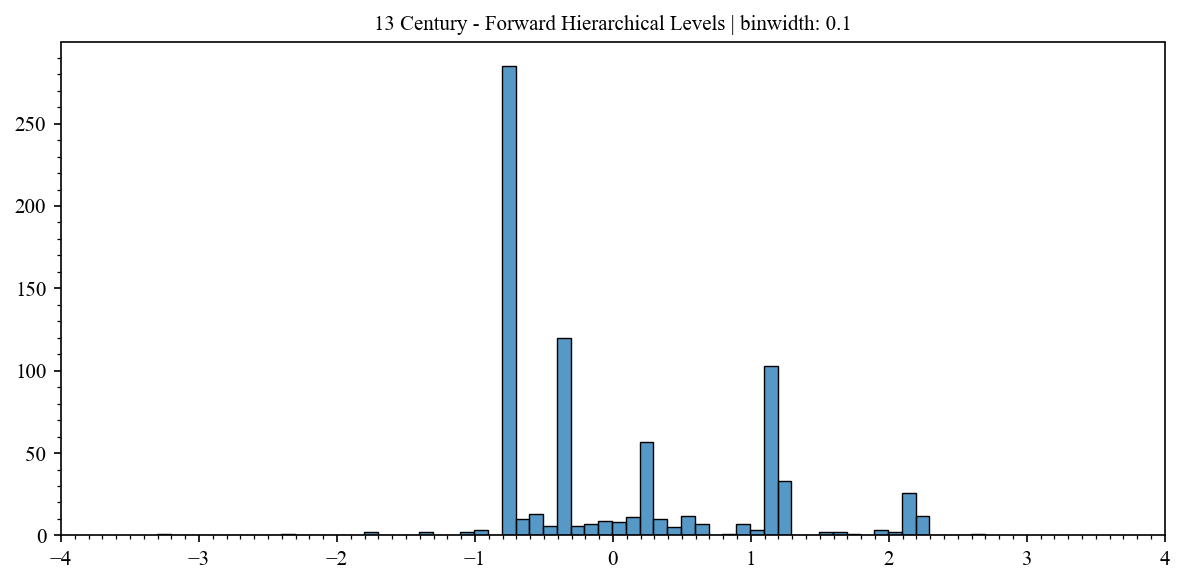

In [38]:
def plot_hirearchy_measure_single_cent(h_measures_df, cent, binwidth, figsize):
    SMALL_SIZE = 10
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 12

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    matplotlib.rcParams['font.serif'] = "Times New Roman"
    matplotlib.rcParams['font.family'] = "serif"
    sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

    plt.figure(figsize=figsize, dpi=150)

    h_levels_tmp = h_measures_df[h_measures_df['cent'] == cent]

    g = sns.histplot(
        data=h_levels_tmp, x='f_hierarchical_levels', binwidth=binwidth
    )
    
    g.set_title('{} Century - Forward Hierarchical Levels | binwidth: {}'.format(cent, binwidth), loc='center')
    g.set(xlabel='', ylabel='', xlim=(-4, 4))
    
    g.xaxis.set_major_locator(plt.MultipleLocator(1))
    g.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
    
    
    g.yaxis.set_major_locator(plt.MultipleLocator(50))
    g.yaxis.set_minor_locator(plt.MultipleLocator(10))

    plt.tight_layout()

    pass

plot_hirearchy_measure_single_cent(h_measures_df=h_measures_df, binwidth=0.1, cent='13', figsize=(8,4))

8it [00:01,  7.71it/s]


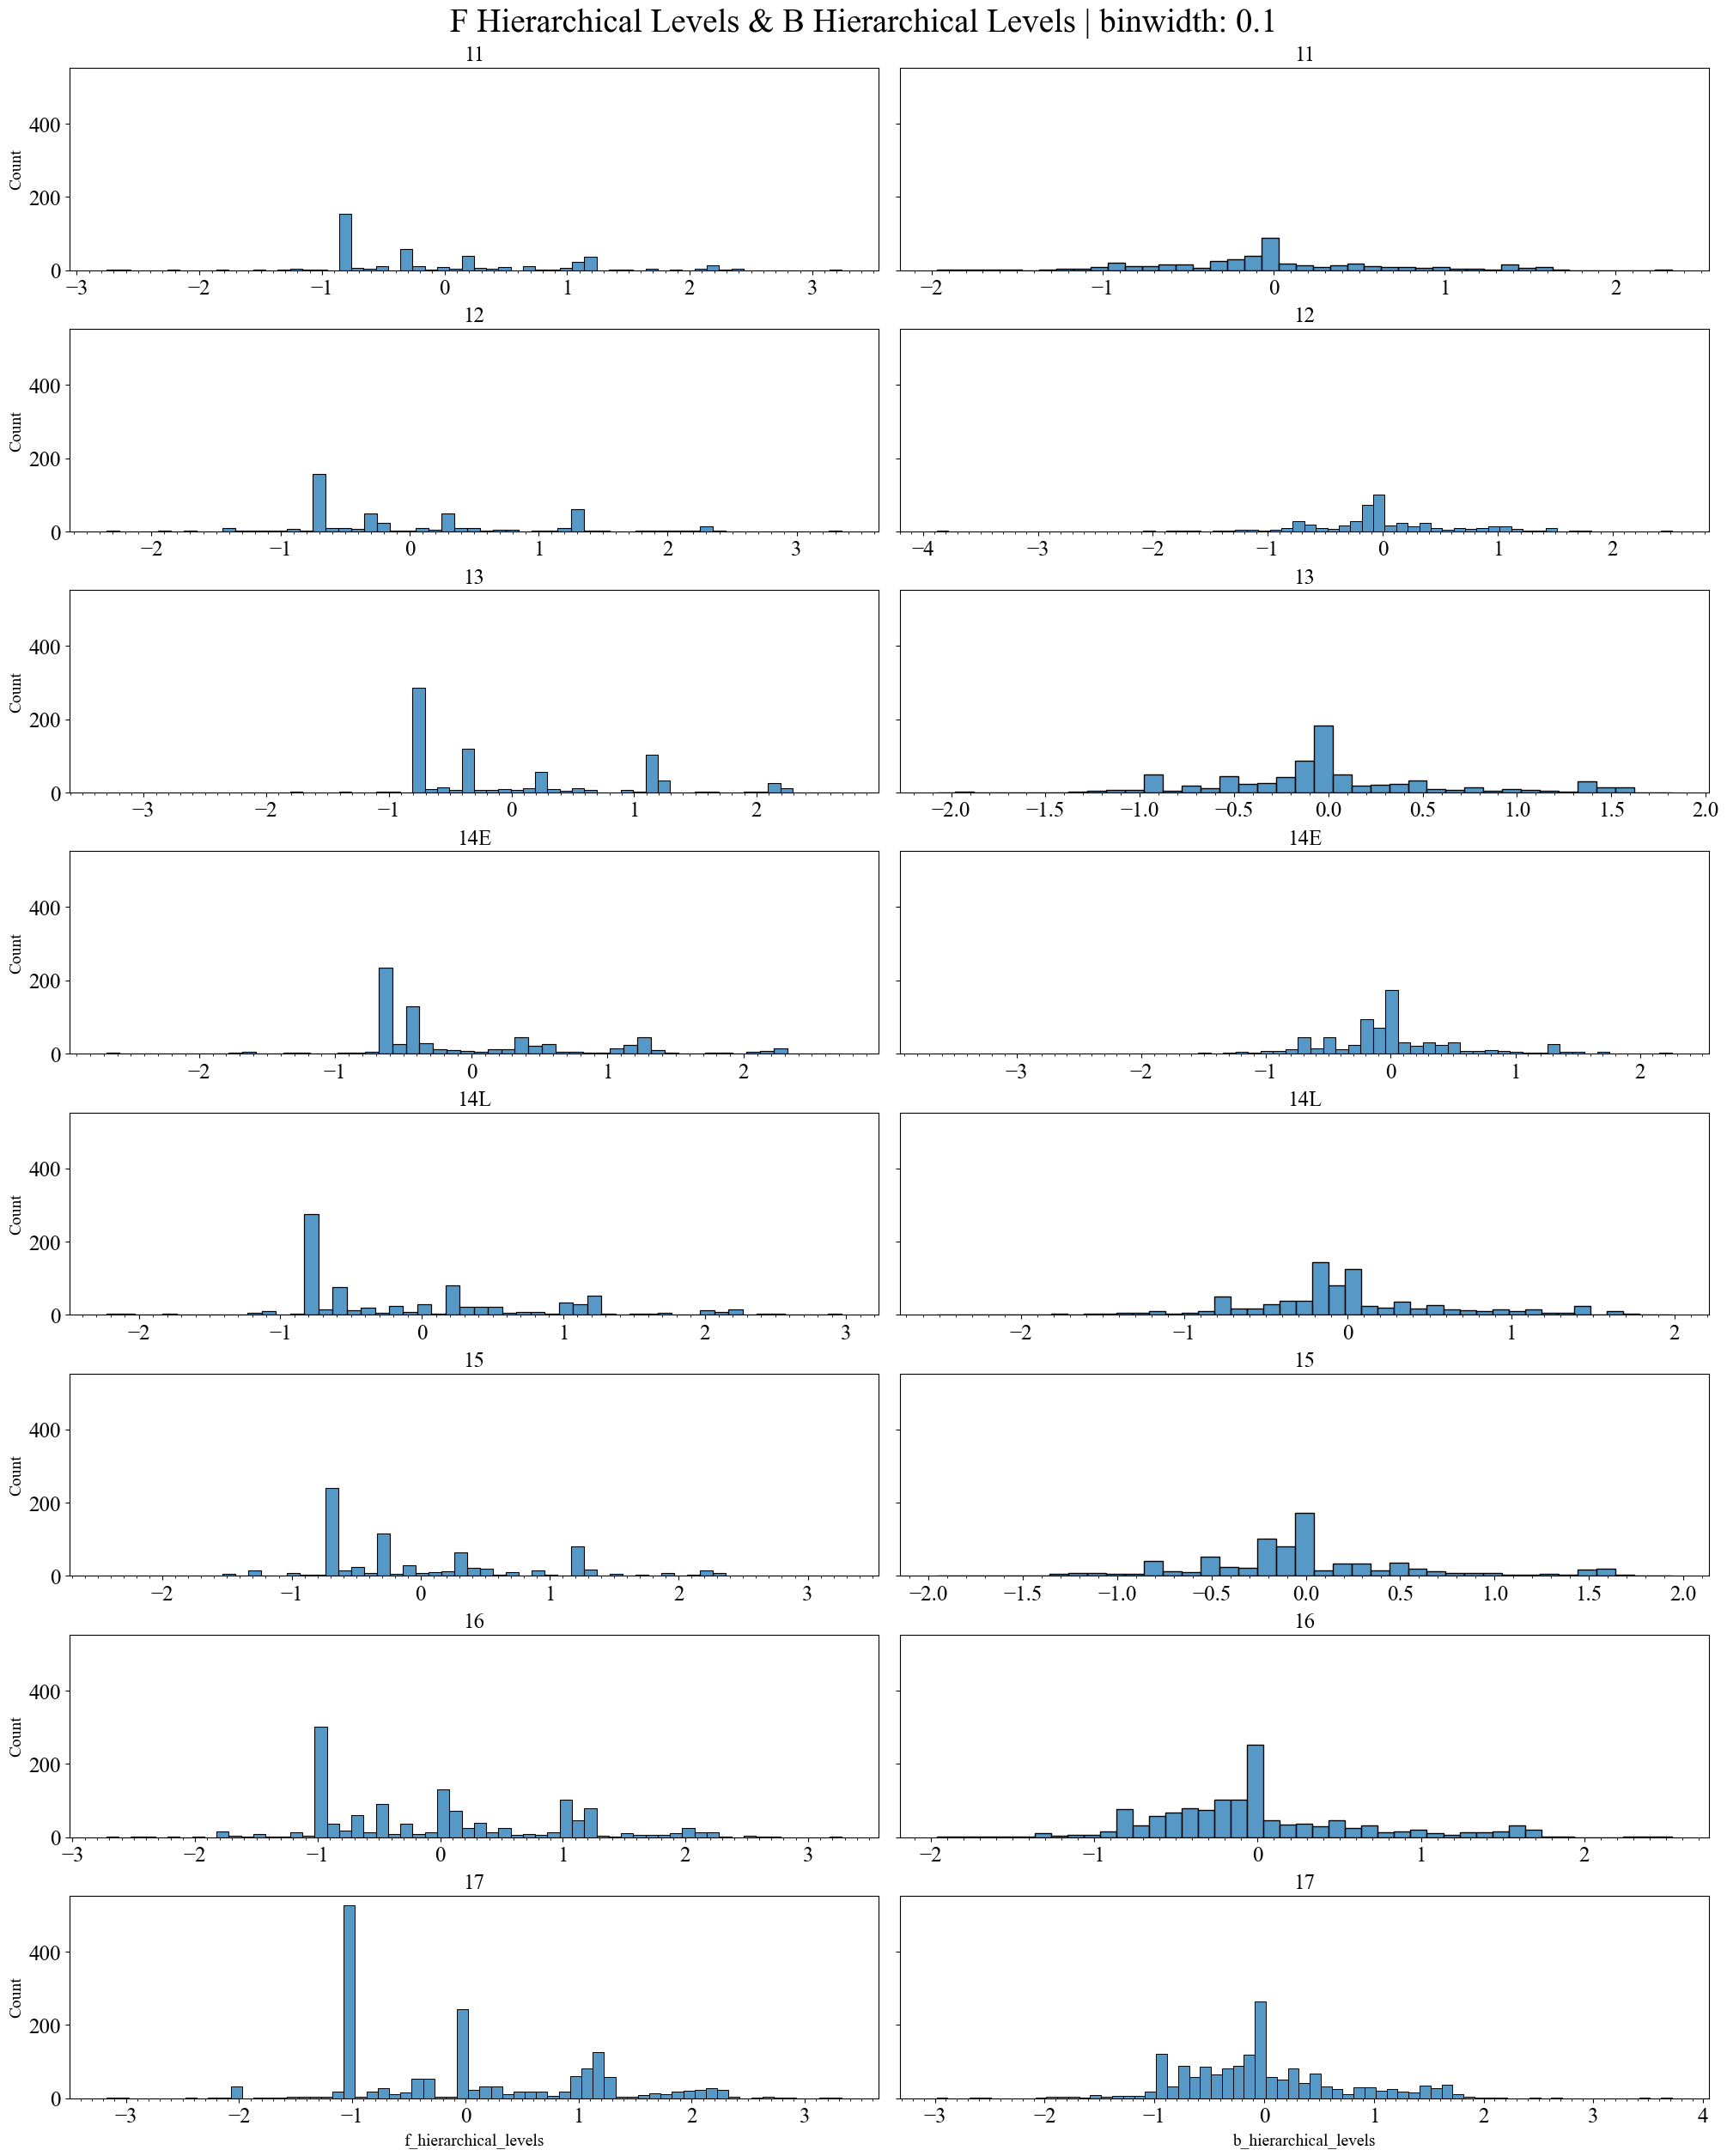

In [39]:
def plot_hirearchy_measure(h_measures_df, binwidth, func_names, ylim_dict=None):
    SMALL_SIZE = 18
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 28

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    matplotlib.rcParams['font.serif'] = "Times New Roman"
    matplotlib.rcParams['font.family'] = "serif"
    sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

    fig, axes = plt.subplots(nrows=len(cent_nets.keys()), ncols=2, constrained_layout=True,
        sharex=False, sharey=True, dpi=100, figsize=(20, 25))

    fig.suptitle('{} | binwidth: {}'.format(
        ' & '.join(func_names).replace('_', ' ').title(), binwidth
    ))
    
    cents = list(cent_nets.keys())
    
    for row, cent in tqdm(enumerate(cents)):

        h_levels_tmp = h_measures_df[h_measures_df['cent'] == cent]

        g = sns.histplot(
            data=h_levels_tmp, x=func_names[0],
            ax=axes[row, 0], binwidth=binwidth
        )
        
        g.set_title('{}'.format(cent), loc='center')
        
        g.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
        
        # write xlabel only for last plot in column
        if cent != cents[-1]:
            g.set(xlabel='')
        
        if False:
            g.set(ylim=(0, ylim_dict[binwidth]) #, xlim=(0, 1), 
                  #xlabel=covars_latex_dicts[x_col], ylabel=covars_latex_dicts[y_col]
            )
            pass
#         g.xaxis.set_major_locator(plt.MultipleLocator(1))
#         g.yaxis.set_major_locator(plt.MultipleLocator(100))
#         print(ylim_dict[binwidth])
        '''-------------------------------'''
        g = sns.histplot(
            data=h_levels_tmp, x= func_names[1],
            ax=axes[row, 1], binwidth=binwidth
        )
        g.set_title('{}'.format(cent), loc='center')
        
        g.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
        
        # write xlabel only for last plot in column
        if cent != cents[-1]:
            g.set(xlabel='')
        
        if False:
            g.set(ylim=(0, ylim_dict[binwidth]) #, xlim=(0, 1), 
                  #xlabel=covars_latex_dicts[x_col], ylabel=covars_latex_dicts[y_col]
            )
            pass
#         g.xaxis.set_major_locator(plt.MultipleLocator(1))
#         g.yaxis.set_major_locator(plt.MultipleLocator(100))

        pass
    pass

binwidth = [0.1, None][0]
# func_name = ['hierarchical_levels', 'forward_hierarchical_levels'][1]
func_names = [
    ('hierarchical_levels', 'f_hierarchical_levels'),
    ('hierarchical_levels', 'b_hierarchical_levels'),
    ('f_hierarchical_levels', 'b_hierarchical_levels'),
    
#     ('f_influence_centrality', 'f_hierarchical_levels')
][-1]
# ylim_dicts={
#     ('forward_hierarchical_levels weighted', 'backward_hierarchical_levels weighted'): {
#         0.25:300, 0.5: 250, 0.75: 300, 1.0: 350, None: 400},
#     ('hierarchical_levels weighted', 'forward_hierarchical_levels weighted'): {None: 400},
#     ('hierarchical_levels weighted', 'backward_hierarchical_levels weighted'): {None: 400},
# }

plot_hirearchy_measure(h_measures_df=h_measures_df, 
                       binwidth=binwidth, 
#                        ylim_dict=ylim_dicts[func_names], 
                       func_names=func_names)

In [40]:
h_measures_df.describe()

,in_degree,out_degree,degree,hierarchical_levels,f_hierarchical_levels,b_hierarchical_levels,f_influence_centrality,b_influence_centrality,f_democracy_coefficient,b_democracy_coefficient,f_hierarchical_incoherence,b_hierarchical_incoherence,diameter directed,cent_num
count,7091.000000,7091.000000,7091.000000,7.091000e+03,7.091000e+03,7.091000e+03,7.091000e+03,7.091000e+03,7.091000e+03,7.091000e+03,7091.000000,7091.000000,7091.000000,7091.000000
mean,1.825130,1.825130,3.650261,2.274619e-16,3.086267e-16,-1.462971e-16,1.029442e-02,4.442248e-01,-1.233368e-07,9.537330e-05,0.342058,0.569917,9.219151,14.803822
std,5.082051,12.603384,13.952916,7.193934e-01,9.595261e-01,6.615653e-01,1.009465e-01,4.969147e-01,1.634034e-07,2.599652e-04,0.044734,0.060223,3.446620,1.819516
min,0.000000,0.000000,1.000000,-2.536001e+00,-3.306071e+00,-3.881795e+00,-2.911449e-04,-1.071606e-03,-3.833591e-07,-3.234392e-07,0.284227,0.489404,6.000000,11.000000
25%,1.000000,0.000000,1.000000,-4.832828e-01,-7.557240e-01,-3.760580e-01,-3.749859e-06,-4.084686e-07,-1.545597e-07,-1.094560e-07,0.302297,0.518166,6.000000,14.100000
50%,1.000000,1.000000,2.000000,-1.442399e-01,-3.135973e-01,-3.627474e-02,3.315069e-08,2.251749e-05,-7.442345e-08,-1.639685e-08,0.332636,0.555706,9.000000,15.000000
75%,1.000000,1.000000,3.000000,5.305199e-01,7.533726e-01,2.816899e-01,3.645688e-06,1.000000e+00,-2.032809e-09,1.221219e-07,0.358902,0.650536,9.000000,16.000000
max,164.000000,509.000000,509.000000,2.750272e+00,3.322592e+00,3.657823e+00,1.000000e+00,1.000001e+00,1.008071e-07,8.035370e-04,0.410666,0.657854,15.000000,17.000000


In [41]:
# cen = '11'
# plt.figure(figsize=(15,8))
# sns.histplot(data=h_measures_df[h_measures_df['cent'] == cent], x='f_influence_centrality')

In [42]:
h_measures_df.columns

Index(['node', 'node func', 'in_degree', 'out_degree', 'degree',
       'hierarchical_levels', 'cent', 'f_hierarchical_levels',
       'b_hierarchical_levels', 'f_influence_centrality',
       'b_influence_centrality', 'f_democracy_coefficient',
       'b_democracy_coefficient', 'f_hierarchical_incoherence',
       'b_hierarchical_incoherence', 'diameter directed',
       'diameter undirected', 'cent_num'],
      dtype='object')

## FHL

In [43]:
h_measures_df['cent_FHL'] = h_measures_df.apply(lambda r: (r['cent'], round(r['f_hierarchical_levels'], 3)), axis=1)

In [44]:
nodes_FHL_df = (
    h_measures_df
    .groupby('node')
    .agg(
        FHL_avg=('f_hierarchical_levels', np.mean), 
        FHL_std=('f_hierarchical_levels', np.std), 
        count_cent=('cent', np.size),
        cent_FHL=('cent_FHL', lambda x: list(x))
    )
    .sort_values(by='FHL_std', ascending=False)
)

if False:
    nodes_FHL_df.to_excel('nodes_FHL_df.xlsx')
    
nodes_FHL_df[nodes_FHL_df.index == 'N geist']

,FHL_avg,FHL_std,count_cent,cent_FHL
node,,,,


In [45]:
print('Number of nodes exists only single century (std=0):', sum(nodes_FHL_df['FHL_std'].isnull()), 'from', len(nodes_FHL_df))

for r in reversed(np.arange(0.5, 2.1, 0.25)):

    print('Number of Nodes with std >= {}: {} from {} | Exists in {} centuries'.format(
        r,
        sum(nodes_FHL_df['FHL_std'] >= r),
        sum(~nodes_FHL_df['FHL_std'].isnull()),
        round(nodes_FHL_df[nodes_FHL_df['FHL_std'] >= r]['count_cent'].mean(), 2)
    ))

Number of nodes exists only single century (std=0): 3748 from 4886
Number of Nodes with std >= 2.0: 0 from 1138 | Exists in nan centuries
Number of Nodes with std >= 1.75: 2 from 1138 | Exists in 2.0 centuries
Number of Nodes with std >= 1.5: 6 from 1138 | Exists in 2.0 centuries
Number of Nodes with std >= 1.25: 19 from 1138 | Exists in 2.26 centuries
Number of Nodes with std >= 1.0: 29 from 1138 | Exists in 2.28 centuries
Number of Nodes with std >= 0.75: 66 from 1138 | Exists in 2.5 centuries
Number of Nodes with std >= 0.5: 172 from 1138 | Exists in 2.66 centuries


## Influence Centrality

In [46]:
'''Forward'''
heads_f_influence_centrality = h_measures_df[h_measures_df['f_influence_centrality'] > 0.1].groupby(['node', 'cent']).agg(count = ('cent', np.size))

head_f_influence = (
    heads_f_influence_centrality
    .reset_index()
    .pivot(index=['node'], columns='cent', values='count')
    .fillna(0)
)

head_f_influence['sum'] = head_f_influence.sum(axis=1)

head_f_influence = head_f_influence.sort_values(by=['sum'], ascending=False)

if False:
    head_f_influence.to_excel(path_dataset_dir + 'influence_cent_forward_high_0.1.xlsx')

head_f_influence

cent,11,12,13,14E,14L,15,16,17,sum
node,,,,,,,,,
MV sollen,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
AX sin,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
AX werden,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
V werden,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
MV wellen,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
MV müssen,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,7.0
MV mögen,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0
MV können,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,5.0
AX haben,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0


In [47]:
'''Backward'''
heads_f_influence_centrality = h_measures_df[h_measures_df['b_influence_centrality'] > 0.1].groupby(['node', 'cent']).agg(count = ('cent', np.size))

head_f_influence = (
    heads_f_influence_centrality
    .reset_index()
    .pivot(index=['node'], columns='cent', values='count')
    .fillna(0)
)

head_f_influence['sum'] = head_f_influence.sum(axis=1)

head_f_influence = head_f_influence.sort_values(by=['sum'], ascending=False)

if False:
    head_f_influence.to_excel(path_dataset_dir + 'influence_cent_backward_high_0.1.xlsx')

head_f_influence

cent,11,12,13,14E,14L,15,16,17,sum
node,,,,,,,,,
AJ/S all,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
PP/O wir,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
AR/S der,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
AJ/O all,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
AR/O der,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
...,...,...,...,...,...,...,...,...,...
AJ/S paraliticus,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
AJ/S om,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
AJ/S offen,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [48]:
[n for n in nodes_all_cent if 'werden' in n]

['AX werden', 'PCPS werden', 'IV werden', 'V werden']

[None, None]

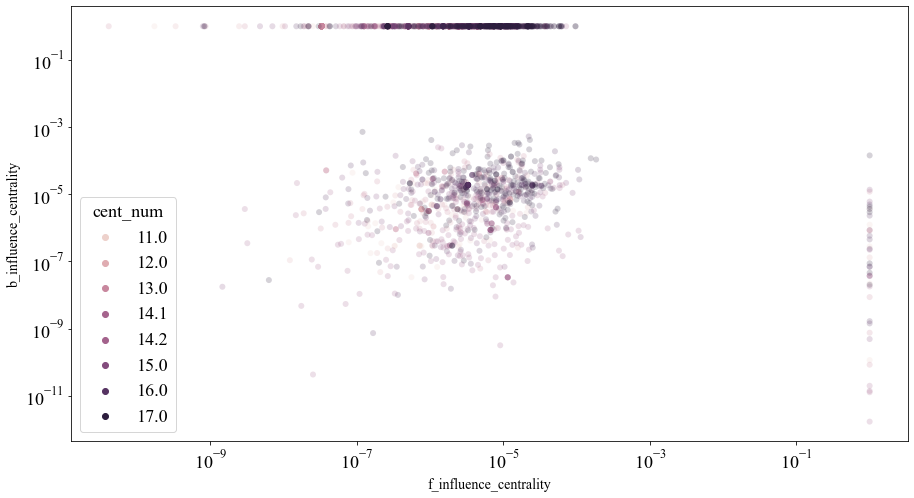

In [49]:
plt.figure(figsize=(15,8))

ax = sns.scatterplot(data=h_measures_df, x='f_influence_centrality', y='b_influence_centrality', 
                     hue='cent_num', alpha=0.2, linewidth=0, legend='full')

ax.set(xscale='log', yscale='log')

# h_measures_df['f_influence_centrality']

Text(0.5, 1.0, 'f_influence_centrality')

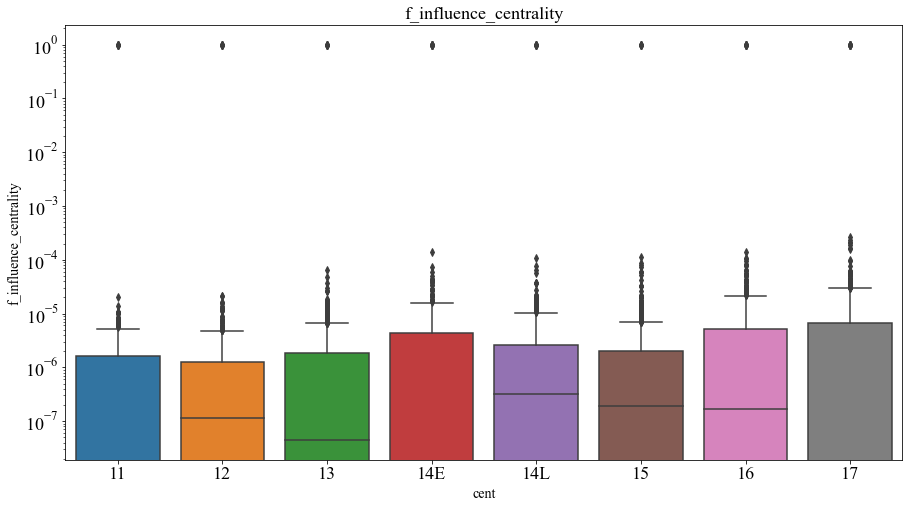

In [50]:
measure = ['f_influence_centrality'][0]

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=h_measures_df, y=measure, x='cent')
ax.set(yscale="log")
ax.set_title(measure)

<AxesSubplot:xlabel='f_hierarchical_levels', ylabel='Count'>

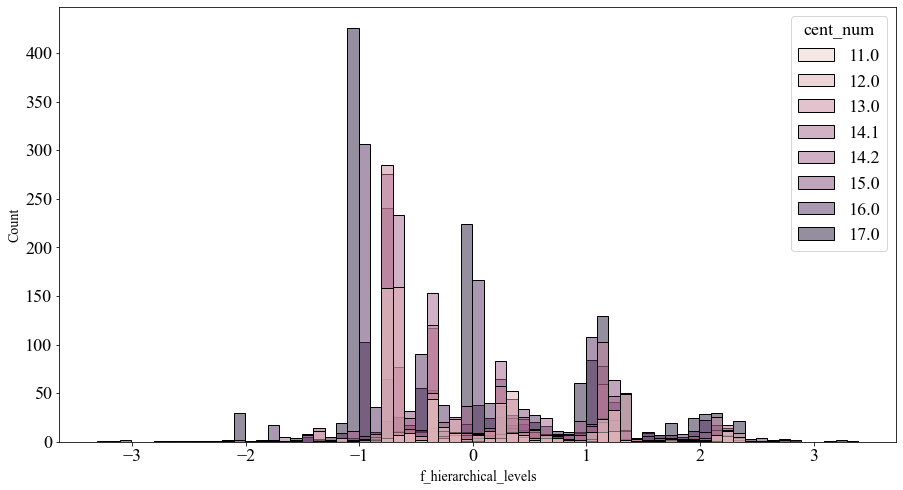

In [51]:
plt.figure(figsize=(15,8))
sns.histplot(data=h_measures_df, x='f_hierarchical_levels', hue='cent_num', binwidth=0.1)

<AxesSubplot:xlabel='b_hierarchical_levels', ylabel='Count'>

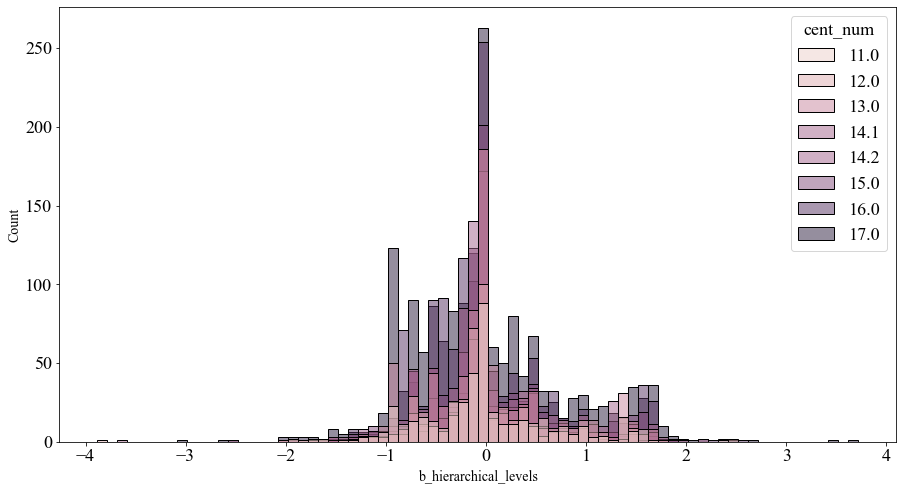

In [52]:
plt.figure(figsize=(15,8))
sns.histplot(data=h_measures_df, x='b_hierarchical_levels', hue='cent_num', binwidth=0.1)

<AxesSubplot:xlabel='hierarchical_levels', ylabel='Count'>

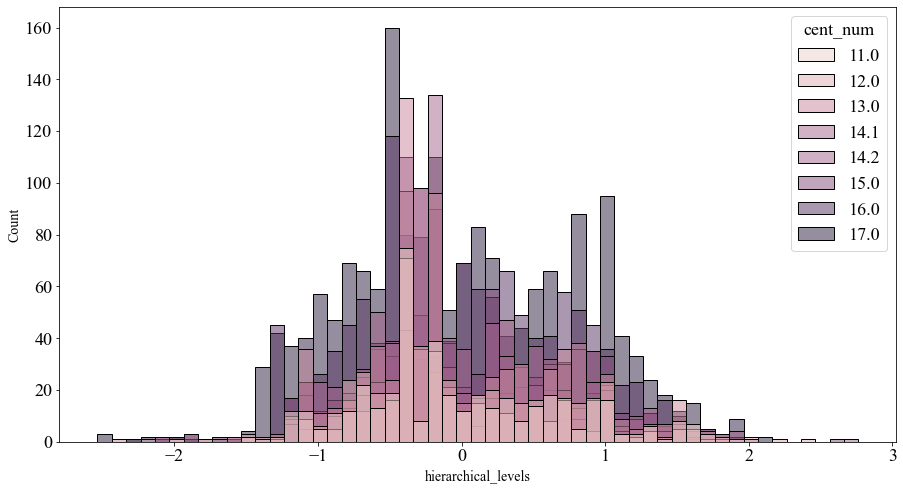

In [53]:
plt.figure(figsize=(15,8))
sns.histplot(data=h_measures_df, x='hierarchical_levels', hue='cent_num', binwidth=0.1)

In [54]:
# plt.figure(figsize=(15,8))
# sns.histplot(
#     data=h_levels_df[h_levels_df['cent'].isin(['11', '17'])], 
#     x='hierarchical_levels', hue='cent')

## Global Measures: Democracy Coeff and Hierarchical Incoherence

In [55]:
dem_forw_df = []

col_weight = 'frequency'

for cent, G in tqdm(cent_nets.items()):
    FHD_adj, FHD_mean, FHD_std = gh.forward_hierarchical_incoherence(G, weight=col_weight)
    
#     b_hierarchical_level_vector, b_influence_centrality_vector, b_hierarchical_diff_adj_sparse, b_democracy_coefficient, b_hierarchical_incoherence = gh.backward_hierarchical_metrics(G, weight='frequency')
    
    hierarchical_level_vector, influence_centrality_vector, hierarchical_diff_adj_sparse, democracy_coefficient, hierarchical_incoherence = gh.forward_hierarchical_metrics(G, weight=col_weight)
    
    dem_forw_df.append(
        {
            'cent': cent,
            'forward_hierarchical_incoherence avg': FHD_mean,
            'forward_hierarchical_incoherence std': FHD_std,
            'forward_democracy_coefficient': gh.forward_democracy_coefficient(G, weight=col_weight),
            'backward_democracy_coefficient': gh.backward_democracy_coefficient(G, weight=col_weight),
            'democracy_coefficient': democracy_coefficient,
            'hierarchical_incoherence': hierarchical_incoherence
        }
    )
    
dem_forw_df = pd.DataFrame(dem_forw_df)
dem_forw_df['cent_num'] = dem_forw_df['cent'].map(centuries)
dem_forw_df

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:07<00:00,  1.12it/s]


,cent,forward_hierarchical_incoherence avg,forward_hierarchical_incoherence std,forward_democracy_coefficient,backward_democracy_coefficient,democracy_coefficient,hierarchical_incoherence,cent_num
0,11,1.0,0.312320,1.008071e-07,-1.094560e-07,1.008071e-07,0.312320,11.0
1,12,1.0,0.284227,-2.362644e-08,-9.542216e-09,-2.362644e-08,0.284227,12.0
2,13,1.0,0.320663,-1.545597e-07,-3.486301e-08,-1.545597e-07,0.320663,13.0
3,14E,1.0,0.332636,-1.521678e-07,-1.776621e-07,-1.521678e-07,0.332636,14.1
4,14L,1.0,0.302297,-7.442345e-08,8.035370e-04,-7.442345e-08,0.302297,14.2
5,15,1.0,0.291179,5.190225e-08,-3.234392e-07,5.190225e-08,0.291179,15.0
6,16,1.0,0.358902,-2.032809e-09,-1.639685e-08,-2.032809e-09,0.358902,16.0
7,17,1.0,0.410666,-3.833591e-07,1.221219e-07,-3.833591e-07,0.410666,17.0


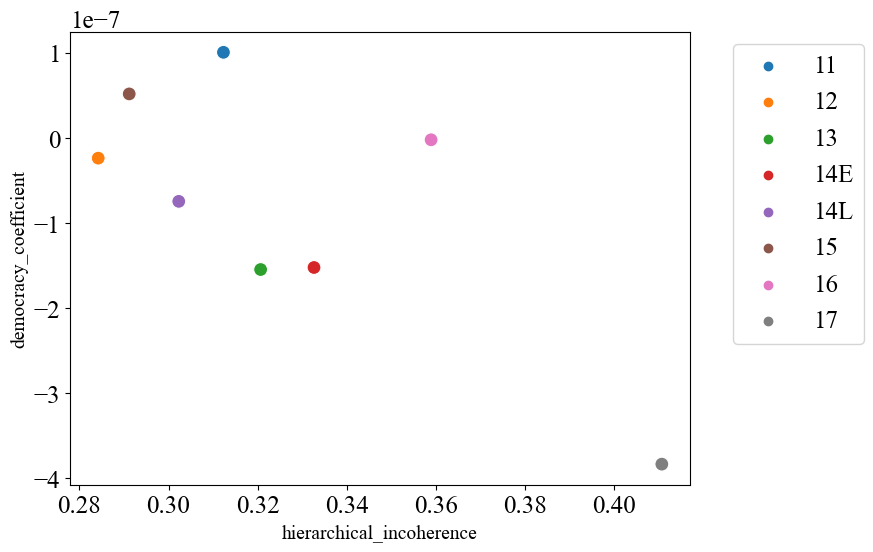

In [56]:
plt.figure(figsize=(8, 6), dpi=100)
ax = sns.scatterplot(data=dem_forw_df, x="hierarchical_incoherence", y="democracy_coefficient", hue='cent',
               s=100, legend='full')
ax.legend(bbox_to_anchor=(1.0, 1.0, 0.3, 0))

In [57]:
dem_forw_df

,cent,forward_hierarchical_incoherence avg,forward_hierarchical_incoherence std,forward_democracy_coefficient,backward_democracy_coefficient,democracy_coefficient,hierarchical_incoherence,cent_num
0,11,1.0,0.312320,1.008071e-07,-1.094560e-07,1.008071e-07,0.312320,11.0
1,12,1.0,0.284227,-2.362644e-08,-9.542216e-09,-2.362644e-08,0.284227,12.0
2,13,1.0,0.320663,-1.545597e-07,-3.486301e-08,-1.545597e-07,0.320663,13.0
3,14E,1.0,0.332636,-1.521678e-07,-1.776621e-07,-1.521678e-07,0.332636,14.1
4,14L,1.0,0.302297,-7.442345e-08,8.035370e-04,-7.442345e-08,0.302297,14.2
5,15,1.0,0.291179,5.190225e-08,-3.234392e-07,5.190225e-08,0.291179,15.0
6,16,1.0,0.358902,-2.032809e-09,-1.639685e-08,-2.032809e-09,0.358902,16.0
7,17,1.0,0.410666,-3.833591e-07,1.221219e-07,-3.833591e-07,0.410666,17.0


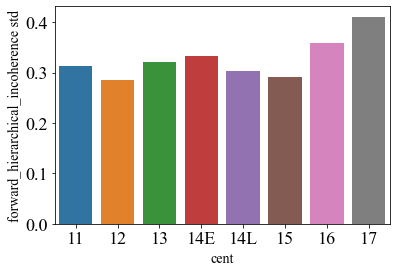

In [58]:
ax = sns.barplot(x="cent", y="forward_hierarchical_incoherence std", data=dem_forw_df)

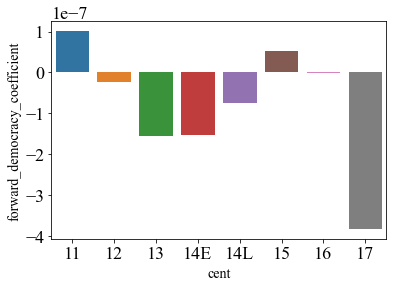

In [59]:
ax = sns.barplot(x="cent", y="forward_democracy_coefficient", data=dem_forw_df)

In [60]:
dem_forw_df

,cent,forward_hierarchical_incoherence avg,forward_hierarchical_incoherence std,forward_democracy_coefficient,backward_democracy_coefficient,democracy_coefficient,hierarchical_incoherence,cent_num
0,11,1.0,0.312320,1.008071e-07,-1.094560e-07,1.008071e-07,0.312320,11.0
1,12,1.0,0.284227,-2.362644e-08,-9.542216e-09,-2.362644e-08,0.284227,12.0
2,13,1.0,0.320663,-1.545597e-07,-3.486301e-08,-1.545597e-07,0.320663,13.0
3,14E,1.0,0.332636,-1.521678e-07,-1.776621e-07,-1.521678e-07,0.332636,14.1
4,14L,1.0,0.302297,-7.442345e-08,8.035370e-04,-7.442345e-08,0.302297,14.2
5,15,1.0,0.291179,5.190225e-08,-3.234392e-07,5.190225e-08,0.291179,15.0
6,16,1.0,0.358902,-2.032809e-09,-1.639685e-08,-2.032809e-09,0.358902,16.0
7,17,1.0,0.410666,-3.833591e-07,1.221219e-07,-3.833591e-07,0.410666,17.0


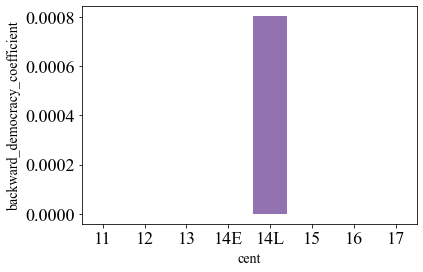

In [61]:
ax = sns.barplot(x="cent", y="backward_democracy_coefficient", data=dem_forw_df)

## Challenges

- https://stackoverflow.com/questions/57458789/get-bin-width-used-for-seaborn-plot
- ITS SO GOOD: https://jakevdp.github.io/PythonDataScienceHandbook/04.10-customizing-ticks.html
- https://stackoverflow.com/questions/56605113/how-to-set-x-axis-ticklabels-in-a-seaborn-plot

In [62]:
raise Exception('The End!')

Exception: End!

# [OLD] yFiles Hierarchical Layout

In [ ]:
path_yfiles_layout = 'D:/GoogleDrive/Research/Linguistic project/German/data/Hierarchical Layout yfiles/'

path_networks = OrderedDict()

path_networks['11'] = path_yfiles_layout + "/Cent11.cyjs" 
path_networks['12'] = path_yfiles_layout + "/Cent12.cyjs" 
path_networks['13'] = path_yfiles_layout + "/Cent13.cyjs" 
path_networks['14E'] = path_yfiles_layout + "/Cent14E.cyjs" 

path_networks['14L'] = path_yfiles_layout + "/Cent14L.cyjs" 
path_networks['15'] = path_yfiles_layout + "/Cent15.cyjs" 
path_networks['16'] = path_yfiles_layout + "/Cent16.cyjs" 
path_networks['17'] = path_yfiles_layout + "/Cent17.cyjs" 

In [ ]:
layouts = OrderedDict()
cen_layers = {}

for cent, path_layout in path_networks.items():
    f = open(path_layout, "r", encoding='utf-8')
    layouts[cent] = json.loads(f.read())
    
    cen_layers[cent] = []
    
    for node in layouts[cent]['elements']['nodes']:
        
        cen_layers[cent].append({
            'name': node['data']['name'],
            'x': node['position']['x'],
            'y': node['position']['y'],
            'y_round': round(node['position']['y'])
        })
        pass
    
    cen_layers[cent] = pd.DataFrame(cen_layers[cent])
    """Now convert unique y value to sequential layer number"""
    map_y_val_to_layer_num = {
        y: l + 1 for l, y in enumerate(sorted(set(cen_layers[cent]['y_round'])))
    }
    
    cen_layers[cent]['layer'] = cen_layers[cent]['y_round'].map(map_y_val_to_layer_num)
    
    cen_layers[cent] = cen_layers[cent].sort_values('layer').reset_index(drop=True)
#     break
    pass
# del layers
map_y_val_to_layer_num
cen_layers['17'].columns
# cen_layers.keys()

In [ ]:
cen_layer_count = []
for cen, cen_layer in cen_layers.items():
    cen_layer_count.append({
        'cent': cen,
        'num layers': cen_layer['layer'].max()
    })
    pass

cen_layer_count = pd.DataFrame(cen_layer_count)

cen_layers['cen_layer_count'] = cen_layer_count

cen_layers['cen_layer_count']

In [ ]:
%matplotlib inline

ax=sns.barplot(x="cent", y="num layers", data=cen_layer_count)
ax.set(ylim=(0, 30), title='Number of Layers in Each Century')

In [ ]:
save_xls(dfs_dict=cen_layers, 
         xls_path=path_yfiles_layout + '/all_cent_layers_yfiles.xlsx', 
         open=True)

# [OLD] Graph Hierarchy 
- How to draw netwrokx graph https://faculty.math.illinois.edu/~hirani/cbmg/graphs.html
- Add x-y axis when drawing with NetworkX https://stackoverflow.com/questions/56994061/how-to-make-x-and-y-axes-appear-when-using-networkx-and-matplotlib
- A cool toturial for visualization https://www.datacamp.com/community/tutorials/networkx-python-graph-tutorial

In [ ]:

graph = nx.gnr_graph(20, 0.4)
nx.draw_networkx(graph)

In [ ]:
l = list(zip(
    graph.nodes(),
#     gh.forward_hierarchical_levels(graph)
    gh.hierarchical_levels(graph)
))

l.sort(key=lambda x: x[1])
l

In [ ]:
level_dict = {}
level_num = 0
prev_layer_level = None
offset = 0

for node, level in l:
    if prev_layer_level is not None:
        offset = 1 - (level - prev_layer_level)
    
#     print('l: ', level, 'o: ', offset)
    
    if level not in level_dict:
        level_dict[level] = []
        level_num += 1
        prev_layer_level = level
        pass
    
    level_dict[level].append(node)
#     print(level + (np.sign(level) * 1))
    graph.nodes[node]['pos'] = (
        (len(level_dict[level]) * 2) + random.uniform(-1, 1),
        level 
    )
    pass

# plt.figure(3,figsize=(12,12)) 

fig, ax = plt.subplots()
fig.set_dpi(150)
fig.set_size_inches(10,10)
pos=nx.get_node_attributes(graph,'pos')

plt.figure(3,figsize=(12,12)) 

nx.draw_networkx(graph, pos, ax=ax)

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

In [ ]:
print('levels: ', len(level_dict))

In [ ]:
node_l_dict = dict(l)
node_l_dict[0] - node_l_dict[1]

In [ ]:
gh.forward_hierarchical_differences(graph)


In [ ]:
(hierarchical_differences_sparse, 
 hierarchical_differences_mean, 
 hierarchical_differences_std) = gh.forward_hierarchical_incoherence(graph)

"""The standard deviation of the distribution is known as the forward hierarchical incoherence and is an important metric which gives a measure of a network's organisation and structure."""
print('mean:', hierarchical_differences_mean, 'std:' , hierarchical_differences_std)

In [ ]:
gh.forward_democracy_coefficient(graph)

In [ ]:
for node in graph.nodes:
    print(node, gh.node_forward_influence_centrality(graph, node))

In [ ]:
gh.forward_influence_centrality(graph)


In [ ]:
gh.hierarchical_levels(graph)
